### Урок 6. Кейс 2. Данные в страховом бизнесе. EDA

### -- Автор: Шенк Евгений Станиславович

### Домашнее задание

1. повторить анализ набора данных WA_Fn-UseC_-Telco-Customer-Churn.csv (желательно придумать какие-то дополнительные признаки)
2. дополнить список моделей еще как минимум тремя (lightgbm, xgboost, svm, knn, naivebayes, сети, что-то еще)
3. на выходе сформировать единую таблицу метрик качества со всеми моделями 
4. сделать выводы о том, какие модели лучше справляются с задачей прогноза оттока на этой выборке
5. есть ли смысл в этапе отборе признаков с точки зрения повышения качества прогнозов
6. (опционально) сделать подбор параметров (без особого усердия) для лучшей (можно нескольких) моделей и проверить качество снова

Выполнение:
    1. выполнен, но  придумать какие-то ценные новые признаки не удалось (в выложенных нотбуках на Keggle создание новых признаков так-же не замечено)  
    2. модель дополнена lightgbm, xgboost, svm  
    3. таблица сформирована, находится вконце нотбука.  
    4. Получилось что даже после подбора гипер параметров другие модели незначительно обходят Логистическую регрессию, но требуют больше затрат времени/сил. Алгоритм SMOTE полволил на всех моделях увеличить метрику f1. Вцелом лучший результат получился на XGBoost Classifier, но с минимальным отрывом и только после подбора гипер параметров (время затраты).  
    5. Отбор признаков (алгоритм RFE) прироста качества (увеличения метрики f1) не давал, а accuracy уменьшалась.  
    6. Подбор гипер параметров проведен для моделей lightgbm и xgboost, без подбора качество было значительно хуже.  

In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

import xgboost as xgb
import lightgbm as lgbm
from sklearn.svm import SVC

In [2]:
telcom = pd.read_csv(r"./WA_Fn-UseC_-Telco-Customer-Churn.csv")
#first few rows
telcom.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


### Data

In [3]:
telcom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


### Data manipulation

In [5]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

### Data preprocessing

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

### Modelling

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.69      0.53      0.60       490

    accuracy                           0.80      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.8026166097838453
Area under curve :  0.7185443893645785 



C:\Users\Eugene\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



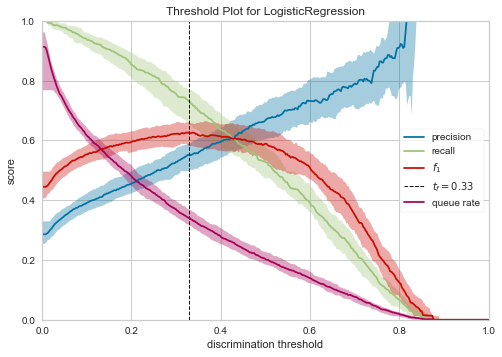

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
#splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

#Function attributes
#dataframe     - processed dataframe
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)

#threshold_plot - if True returns threshold plot for model
    
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

### SMOTE

- Randomly pick a point from the minority class.
- Compute the k-nearest neighbors (for some pre-specified k) for this point.
- Add k new points somewhere between the chosen point and each of its neighbors

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1268
           1       0.59      0.70      0.64       490

    accuracy                           0.78      1758
   macro avg       0.73      0.76      0.74      1758
weighted avg       0.80      0.78      0.79      1758

Accuracy   Score :  0.7815699658703071
Area under curve :  0.7559196549282173 



C:\Users\Eugene\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



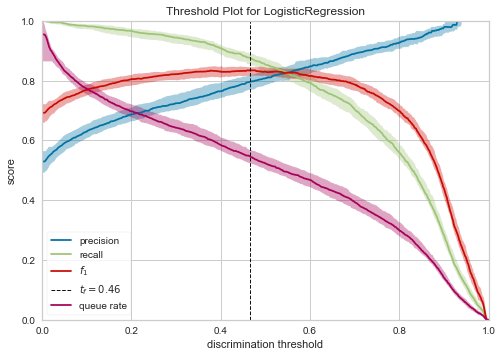

In [9]:
from imblearn.over_sampling import SMOTE

cols    = [i for i in telcom.columns if i not in Id_col+target_col]

smote_X = telcom[cols]
smote_Y = telcom[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)
###



logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

### Feature selection

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [10]:
test_X.shape

(1758, 33)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.70      0.78      1268
           1       0.49      0.76      0.60       490

    accuracy                           0.71      1758
   macro avg       0.69      0.73      0.69      1758
weighted avg       0.77      0.71      0.73      1758

Accuracy   Score :  0.7138794084186576
Area under curve :  0.7284040430052148 



C:\Users\Eugene\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



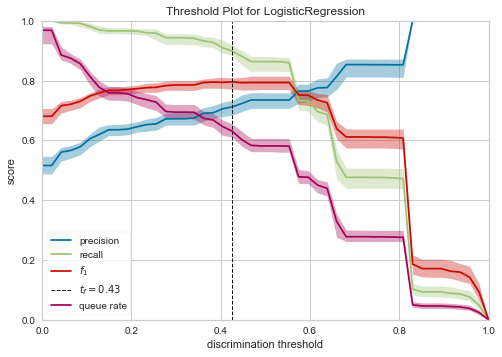

In [11]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()

rfe = RFE(logit,10)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in telcom.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#separating train and test data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
telecom_churn_prediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

### chi-square

- Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
- uses the chi squared (chi^2) statistical test for non-negative features to select the best features

In [12]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in telcom.columns if i not in Id_col + target_col ]

#dataframe with non negative values
df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit    = select.fit(df_x,df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

scores
[2.54297062e-01 1.33482766e+02 8.18577694e+01 1.31271509e+02
 9.29483891e-02 1.47165601e+02 3.12098318e+01 2.02160070e+01
 1.35439602e+02 1.73206148e+01 1.59306111e+01 1.04979224e+02
 3.88864216e+00 8.68247305e-01 6.51465136e+00 7.11376111e+01
 3.72082851e+02 2.85475152e+02 5.16714004e+02 1.76608724e+02
 4.86223101e+02 7.66190658e+01 9.99725387e+01 4.24113152e+02
 4.47251434e+01 4.96199796e+02 2.38616006e+00 3.12932969e+01
 6.29955193e+01 2.87501128e+02 1.63773281e+04 3.65307468e+03
 6.29630810e+05]
P - Values
[6.14065505e-001 7.08954608e-031 1.46240915e-019 2.15953960e-030
 7.60461827e-001 7.21988253e-034 2.31590182e-008 6.91717063e-006
 2.64595220e-031 3.15742928e-005 6.57073922e-005 1.23423173e-024
 4.86137123e-002 3.51440986e-001 1.06989295e-002 3.33158163e-017
 6.58713045e-083 4.81399951e-064 2.19511926e-114 2.66631661e-040
 9.45428638e-108 2.07328356e-018 1.54524820e-023 3.10584857e-094
 2.26727030e-011 6.38005232e-110 1.22413991e-001 2.21844282e-008
 2.07177341e-015 1.741

RandomForestClassifier(criterion='entropy', max_depth=3)

 Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.97      0.86      1268
           1       0.76      0.27      0.40       490

    accuracy                           0.77      1758
   macro avg       0.77      0.62      0.63      1758
weighted avg       0.77      0.77      0.73      1758

Accuracy   Score :  0.7736063708759955
Area under curve :  0.6195470932852636 



C:\Users\Eugene\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



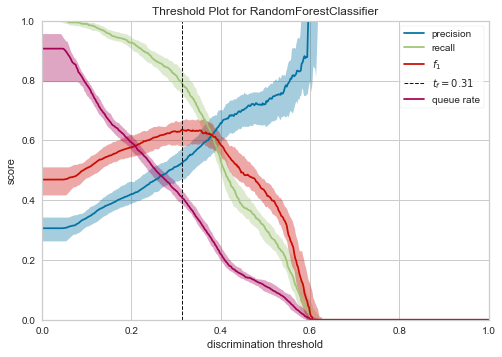

In [13]:
from sklearn.ensemble import RandomForestClassifier

#function attributes
#columns  - column used
#nf_estimators   - The number of trees in the forest.
#estimated_tree  - tree number to be displayed
#maximum_depth   - depth of the tree
#criterion_type  - split criterion type ["gini" or "entropy"]
#Model performance - prints performance of model

def plot_tree_randomforest(columns,nf_estimators,
                           estimated_tree,maximum_depth,
                           criterion_type,model_performance = None) :
    
    dataframe = df_telcom_og[columns + target_col].copy()
    
    #train and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    #graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
    #                                    rounded=True,proportion = False,
    #                        feature_names = columns, 
    #                        precision  = 2,
    #                        class_names=["Not churn","Churn"],
    #                        filled = True))
    #display(graph)
    
    #model performance
    if model_performance == True :
        telecom_churn_prediction(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 columns,"features",threshold_plot = True)
        

cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
plot_tree_randomforest(cols1,100,99,3,"entropy",True)

### LightGBM Classifier

LGBMClassifier(learning_rate=0.01, max_depth=50, n_estimators=200, num_leaves=5,
               random_state=123, reg_alpha=0, reg_lambda=0, subsample=1)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1268
           1       0.52      0.79      0.63       490

    accuracy                           0.74      1758
   macro avg       0.71      0.76      0.72      1758
weighted avg       0.80      0.74      0.75      1758

Accuracy   Score :  0.7417519908987485
Area under curve :  0.7577431919139895 



C:\Users\Eugene\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



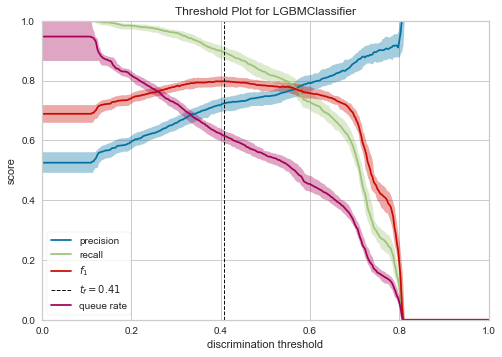

In [14]:
lgbm_c = lgbm.LGBMClassifier(learning_rate = 0.01,
                            max_depth = 50,
                            num_leaves = 5,
                            n_estimators = 200,
                            subsample= 1,
                            reg_alpha = 0,
                            reg_lambda = 0,
                            n_jobs=-1,
                            random_state=123)

cols = [i for i in telcom.columns if i not in Id_col + target_col]
telecom_churn_prediction(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)

### XGBoost Classifier

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              random_state=123, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.77      0.82      1268
           1       0.56      0.74      0.64       490

    accuracy                           0.76      1758
   macro avg       0.72      0.76      0.73      1758
weighted avg       0.79      0.76      0.77      1758

Accuracy   Score :  0.7639362912400455
Area under curv

C:\Users\Eugene\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



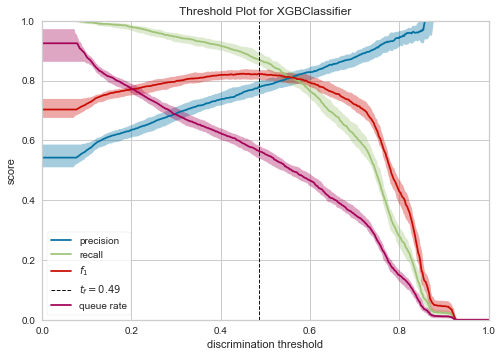

In [15]:
xgc = xgb.XGBClassifier(learning_rate = 0.01,
                        max_depth = 5,
                        n_estimators = 200,
                        subsample= 1,
                        reg_alpha = 0,
                        reg_lambda = 0,
                        n_jobs=-1,
                        random_state=123)


telecom_churn_prediction(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)

### Support vector classifier

In [16]:
#Support vector classifier
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=123, shrinking=True,
               tol=0.001, verbose=False)

cols = [i for i in telcom.columns if i not in Id_col + target_col]
telecom_churn_prediction(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = False)

SVC(gamma=1.0, kernel='linear', probability=True, random_state=123)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1268
           1       0.60      0.67      0.63       490

    accuracy                           0.78      1758
   macro avg       0.73      0.75      0.74      1758
weighted avg       0.79      0.78      0.79      1758

Accuracy   Score :  0.7815699658703071
Area under curve :  0.7471544453743643 



C:\Users\Eugene\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Performance evaluation

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Logistic Regression(Baseline_model)")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Logistic Regression(SMOTE)")
model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Logistic Regression(RFE)")


rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model4 = model_report(rfc,train_X,test_X,train_Y,test_Y,
                      "Random Forest Classifier")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model5 = model_report(rfc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Random Forest Classifier (SMOTE)")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model6 = model_report(rfc,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Random Forest Classifier (RFE)")

light = lgbm.LGBMClassifier(learning_rate = 0.01,
                            max_depth = 50,
                            num_leaves = 3,
                            n_estimators = 1000,
                            subsample= 1,
                            reg_alpha = 15,
                            reg_lambda = 15,
                            n_jobs=-1,
                            random_state=123)
model7 = model_report(light,train_X,test_X,train_Y,test_Y,
                      "LightGBM Classifier")
model8 = model_report(light,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LightGBM Classifier (SMOTE)")
model9 = model_report(light,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "LightGBM Classifier (RFE)")

xgboost = xgb.XGBClassifier(learning_rate = 0.01,
                            max_depth = 3,
                            n_estimators = 1000,
                            subsample= 1,
                            reg_alpha = 15,
                            reg_lambda = 0,
                            n_jobs=-1,
                            random_state=123)
model10 = model_report(xgboost,train_X,test_X,train_Y,test_Y,
                      "XGBoost Classifier")
model11 = model_report(xgboost,os_smote_X,test_X,os_smote_Y,test_Y,
                      "XGBoost Classifier (SMOTE)")
model12 = model_report(xgboost,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "XGBoost Classifier (RFE)")

svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=123, shrinking=True,
               tol=0.001, verbose=False)
model13 = model_report(svc_lin,train_X,test_X,train_Y,test_Y,
                      "Support vector Classifier")
model14 = model_report(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Support vector Classifier (SMOTE)")
model15 = model_report(svc_lin,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Support vector Classifier (RFE)")

#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model4,model5,model6,
                                model7,model8,model9,
                                model10,model11,model12,
                                model13,model14,model15,],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

model_performances

,Model,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve,Kappa_metric
0,Logistic Regression(Baseline_model),0.802048,0.528571,0.688830,0.598152,0.718150,0.469834
1,Logistic Regression(SMOTE),0.781570,0.697959,0.591696,0.640449,0.755920,0.485112
2,Logistic Regression(RFE),0.713879,0.761224,0.491436,0.597278,0.728404,0.390963
3,Random Forest Classifier,0.795222,0.457143,0.704403,0.554455,0.691505,0.429233
4,Random Forest Classifier (SMOTE),0.769056,0.748980,0.564615,0.643860,0.762897,0.477919
5,Random Forest Classifier (RFE),0.718430,0.753061,0.496635,0.598540,0.729054,0.395467
6,LightGBM Classifier,0.803754,0.508163,0.705382,0.590747,0.713072,0.466126
7,LightGBM Classifier (SMOTE),0.754835,0.771429,0.542324,0.636900,0.759926,0.460208
8,LightGBM Classifier (RFE),0.703072,0.793878,0.480247,0.598462,0.730929,0.384771
9,XGBoost Classifier,0.805461,0.520408,0.704420,0.598592,0.718012,0.474010


In [18]:
"""model_xgb = xgb.XGBClassifier(learning_rate = 0.02,
                                max_depth = 10,
                                num_leaves = 15,
                                n_estimators = 150,
                                subsample= 1,
                                reg_alpha = 0,
                                reg_lambda = 0,
                                n_jobs=-1,
                                random_state=123)
model_xgb.fit(train_X, train_Y)"""

'model_xgb = xgb.XGBClassifier(learning_rate = 0.02,\n                                max_depth = 10,\n                                num_leaves = 15,\n                                n_estimators = 150,\n                                subsample= 1,\n                                reg_alpha = 0,\n                                reg_lambda = 0,\n                                n_jobs=-1,\n                                random_state=123)\nmodel_xgb.fit(train_X, train_Y)'

In [19]:
params = {'n_estimators':[1000], 
          'max_depth':[3, 4, 5, 6, 7, 8],
          'learning_rate':[0.01],
          'reg_alpha':[0, 10, 15, 25],
          'reg_lambda':[0, 10, 15, 25]}

In [20]:
"""from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

cv=KFold(n_splits=5, random_state=2177, shuffle=True)"""

'from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV\n\ncv=KFold(n_splits=5, random_state=2177, shuffle=True)'

In [21]:
"""
%%time

rs = GridSearchCV(model_xgb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(train_X, train_Y)
"""

"\n%%time\n\nrs = GridSearchCV(model_xgb, params, scoring='f1', cv=cv, n_jobs=-1)\nrs.fit(train_X, train_Y)\n"

In [22]:
"""rs.best_params_"""

'rs.best_params_'

In [23]:
"""rs.best_score_"""

'rs.best_score_'

In [24]:
"""
# lgbm
{'learning_rate': 0.01,
 'max_depth': 50,
 'n_estimators': 1000,
 'num_leaves': 5,
 'reg_alpha': 15,
 'reg_lambda': 15}

# xgb
{'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 1000,
 'reg_alpha': 15,
 'reg_lambda': 0}
"""

"\n# lgbm\n{'learning_rate': 0.01,\n 'max_depth': 50,\n 'n_estimators': 1000,\n 'num_leaves': 5,\n 'reg_alpha': 15,\n 'reg_lambda': 15}\n\n# xgb\n{'learning_rate': 0.01,\n 'max_depth': 3,\n 'n_estimators': 1000,\n 'reg_alpha': 15,\n 'reg_lambda': 0}\n"